In [1]:
!pip install transformers==3.0.0

     |████████████████████████████████| 754 kB 4.3 MB/s 
     |████████████████████████████████| 3.0 MB 18.5 MB/s 
     |████████████████████████████████| 1.2 MB 40.6 MB/s 
     |████████████████████████████████| 895 kB 50.5 MB/s 


In [2]:
!pip install -q kaggle

In [4]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-11-10 18:11:20          15624  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           9475  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           4266  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3467  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [6]:
!kaggle datasets download -d kotartemiy/topic-labeled-news-dataset --force

 53% 5.00M/9.45M [00:00<00:00, 8.84MB/s]
100% 9.45M/9.45M [00:00<00:00, 14.9MB/s]


In [7]:
!unzip topic-labeled-news-dataset.zip
!unzip topic-labeled-news-dataset.zip

Archive:  topic-labeled-news-dataset.zip
  inflating: labelled_newscatcher_dataset.csv  
Archive:  topic-labeled-news-dataset.zip
replace labelled_newscatcher_dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: r
new name: train.csv
  inflating: train.csv               


In [8]:
!head -n 10 train.csv

topic;link;domain;published_date;title;lang
SCIENCE;https://www.eurekalert.org/pub_releases/2020-08/dbnl-acl080620.php;eurekalert.org;2020-08-06 13:59:45;A closer look at water-splitting's solar fuel potential;en
SCIENCE;https://www.pulse.ng/news/world/an-irresistible-scent-makes-locusts-swarm-study-finds/jy784jw;pulse.ng;2020-08-12 15:14:19;An irresistible scent makes locusts swarm, study finds;en
SCIENCE;https://www.express.co.uk/news/science/1322607/artificial-intelligence-warning-machine-learning-algorithm-social-media-data;express.co.uk;2020-08-13 21:01:00;Artificial intelligence warning: AI will know us better than we know ourselves;en
SCIENCE;https://www.ndtv.com/world-news/glaciers-could-have-sculpted-mars-valleys-study-2273648;ndtv.com;2020-08-03 22:18:26;Glaciers Could Have Sculpted Mars Valleys: Study;en
SCIENCE;https://www.thesun.ie/tech/5742187/perseid-meteor-shower-tonight-time-uk-see/;thesun.ie;2020-08-12 19:54:36;Perseid meteor shower 2020: What time and how to see the 

In [9]:
!wc -l train.csv

108775 train.csv


In [10]:
import os, sys, random
import itertools

import numpy as np
import pandas as pd

import torch
from torch import optim
import torch.nn.functional as F

from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [11]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    NUM_LABELS = 8
    
    def __init__(self, dataset_path, tokenizer, split,row_indexes=None):
        if (split=='train' or split=='dev'):
          df = pd.read_csv(dataset_path,sep=";")
          df['label'] = df['topic'].factorize()[0]
          label_id_df = df[['topic', 'label']].drop_duplicates().sort_values('label')
          label_to_id = dict(label_id_df.values)
          id_to_label = dict(label_id_df[['label', 'topic']].values)
        else:
          df = pd.read_csv(dataset_path, sep=";")
          df['label'] = 0
        if(row_indexes != None):
          df = df.iloc[row_indexes,:]
          df.reset_index(drop=True, inplace=True) 
        df['title'] = df['title'].str.lower()

        
        self.data = df
        self.tokenizer = tokenizer
    
    def __getitem__(self, index):
        data = self.data.loc[index,:]
        text, label = data['title'], data['label']
        subwords = self.tokenizer(text, padding='max_length', truncation=True, max_length=360)
        item = {key: torch.tensor(val) for key, val in subwords.items()}
        item['labels'] = torch.tensor(label)
        return item
    
    def __len__(self):
        return len(self.data)

In [12]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
set_seed(42)

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
config = BertConfig.from_pretrained('bert-base-uncased')
config.num_labels = CustomDataset.NUM_LABELS

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [14]:
train_dataset_path = '/content/train.csv'
dev_dataset_path = '/content/labelled_newscatcher_dataset.csv'

train_dataset = CustomDataset(train_dataset_path, tokenizer, "train")
dev_dataset = CustomDataset(dev_dataset_path, tokenizer, "dev")

train_loader = DataLoader(dataset=train_dataset,  batch_size=8, shuffle=True) 
dev_loader = DataLoader(dataset=dev_dataset,  batch_size=8, shuffle=False)

In [15]:
randomed_indexes = random.sample(range(0, 100000), 10000)
train_indexes = randomed_indexes[:20000]
dev_indexes = randomed_indexes[5000:]
test_indexes = random.sample(range(0, 25000), 2000)

In [16]:
train_dataset_path = '/content/train.csv'
dev_dataset_path = '/content/labelled_newscatcher_dataset.csv'
print(train_indexes)
print(dev_indexes)
train_dataset = CustomDataset(train_dataset_path, tokenizer, "train",train_indexes)
dev_dataset = CustomDataset(dev_dataset_path, tokenizer, "dev",dev_indexes)

train_loader = DataLoader(dataset=train_dataset,  batch_size=8, shuffle=True) 
dev_loader = DataLoader(dataset=dev_dataset,  batch_size=8, shuffle=False)

[83810, 14592, 3278, 97196, 36048, 32098, 29256, 18289, 96530, 13434, 88696, 97080, 71482, 11395, 77397, 55302, 4165, 3905, 12280, 28657, 30495, 66237, 78907, 3478, 73563, 26062, 93850, 85181, 91924, 71426, 54987, 28893, 58878, 77236, 36463, 851, 99458, 20926, 91506, 55392, 44597, 36421, 20379, 28221, 44118, 13396, 12156, 49797, 12676, 47052, 45082, 79131, 34671, 5695, 95647, 60217, 70284, 16361, 49615, 10328, 72357, 38427, 82397, 81070, 47400, 75674, 25203, 92349, 9116, 6006, 86673, 29871, 37930, 10458, 30512, 13238, 49823, 36434, 59429, 83320, 47819, 21319, 48520, 46566, 27460, 87841, 34993, 91988, 89593, 84939, 9358, 79840, 83227, 22431, 70010, 95568, 32087, 21417, 60589, 49735, 35382, 83886, 90198, 73000, 28785, 89733, 42504, 7331, 30021, 4207, 41347, 52581, 35093, 8675, 27653, 74341, 94098, 41245, 27869, 85909, 65435, 51856, 84259, 60142, 18726, 34718, 18301, 32325, 97647, 73579, 70644, 34438, 97912, 76622, 56155, 76484, 52350, 47447, 28746, 18131, 66784, 64686, 11915, 99061, 6175

In [17]:
print(train_dataset[0])
print(len(train_dataset))
print(len(dev_dataset))

{'input_ids': tensor([  101,  7570, 14510,  2103,  2003,  2275,  2000,  2202,  2019,  3668,
         2006,  1011,  3898,  3338,  2127,  2101,  2023,  2095,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

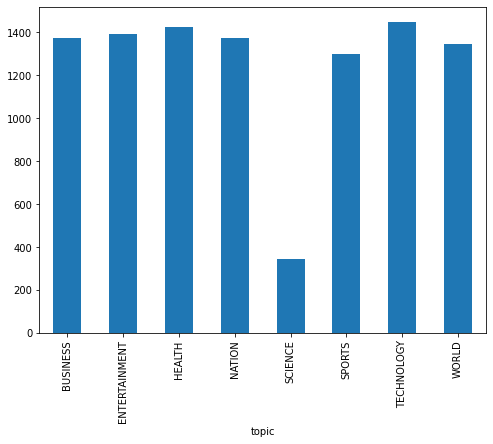

In [30]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
train_dataset.data.groupby('topic').title.count().plot.bar(ylim=0)
plt.show()

In [18]:
optimizer = optim.Adam(model.parameters(), lr=3e-5)
model = model.cuda()

In [19]:
# Train
device = 'cuda'
n_epochs = 4
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch in enumerate(train_pbar):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f}".format((epoch+1),
            total_train_loss/(i+1)))
        
    # # eval on dev
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(dev_loader, leave=True, total=len(dev_loader))
    for i, batch in enumerate(pbar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]

        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        pbar.set_description("DEV LOSS:{:.4f} ".format(total_loss/(i+1)))

        logits = outputs[1]
        batch_hyp = torch.argmax(logits, dim=-1)
        list_hyp += batch_hyp.cpu().numpy().tolist()
        list_label += labels.cpu().numpy().tolist()
    
    acc = accuracy_score(list_label, list_hyp)
    f1 = f1_score(list_label, list_hyp, average='macro')
    rec = recall_score(list_label, list_hyp, average='macro')
    prec = precision_score(list_label, list_hyp, average='macro')

    print(f"epoch: {epoch}")
    print("Acc: ", acc)
    print("F1: ", f1)
    print("recall: ", rec)
    print("precision: ", prec)

DEV LOSS:0.4482 : 100%|██████████| 625/625 [04:01<00:00,  2.59it/s]


epoch: 0
Acc:  0.8592
F1:  0.8618934950927724
recall:  0.8583718437829051
precision:  0.8783998830092938


DEV LOSS:0.2269 : 100%|██████████| 625/625 [04:01<00:00,  2.59it/s]


epoch: 1
Acc:  0.9328
F1:  0.933311638343415
recall:  0.9325550263952742
precision:  0.9358017928395606


DEV LOSS:0.1357 : 100%|██████████| 625/625 [04:02<00:00,  2.58it/s]


epoch: 2
Acc:  0.962
F1:  0.9599153786344448
recall:  0.9598451371010686
precision:  0.960909326464795


DEV LOSS:0.0640 : 100%|██████████| 625/625 [03:58<00:00,  2.62it/s]

epoch: 3
Acc:  0.9828
F1:  0.9802973097902299
recall:  0.9787917937015023
precision:  0.9818990273844324


In [20]:
model.eval()
torch.save(model.state_dict(),'topic_classification_model.bin')

In [21]:
loaded_model = BertForSequenceClassification.from_pretrained('/content/topic_classification_model.bin', config=config)

In [22]:
test_dataset = CustomDataset(dev_dataset_path, tokenizer, "test",test_indexes)
test_loader = DataLoader(dataset=test_dataset,  batch_size=8, shuffle=False)
print(test_dataset[0])
print(len(test_dataset))

{'input_ids': tensor([  101, 10022,  8816,  1024,  5351,  2257,  1006,  2885,  1007,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

In [23]:
model= loaded_model
model.eval()
torch.set_grad_enabled(False)
device = 'cpu'
total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch in enumerate(pbar):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs[0]

    logits = outputs[1]
    batch_hyp = torch.argmax(logits, dim=-1)
    list_hyp += batch_hyp.cpu().numpy().tolist()
    list_label += labels.cpu().numpy().tolist()
    

print(list_label)
print(list_hyp)


df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('pred_tc.csv', index=False)

print(df)

100%|██████████| 250/250 [39:02<00:00,  9.37s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [46]:
trans = {
    0:'SCIENCE',
    1:'TECHNOLOGY',
    2:'HEALTH',
    3:'WORLD',
    4:'ENTERTAINMENT',
    5:'SPORTS',
    6:'BUSINESS',
    7:'NATION'
}
def predict(text):
  subwords = tokenizer.encode(text)
  subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

  logits = model(subwords)[0]
  label = torch.argmax(logits, dim=-1).item()
  return trans[label]

In [47]:
predict("A closer look at water-splitting's solar fuel potential")

'SCIENCE'

In [48]:
predict("Come See What It’s Like To Play Microsoft Flight Simulator")

'TECHNOLOGY'

In [49]:
predict("I nearly died as my body burned itself from the inside out – after mistaking life-threatening disorder for i")

'HEALTH'

In [50]:
predict("Hell ant’ found in 99 million year old amber")

'SCIENCE'